# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2023-spring@googlegroups.com

Slide:    [Link](https://docs.google.com/presentation/d/18LkR8qulwSbi3SVoLl1XNNGjQQ_qczs_35lrJWOmHCk/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/t/c76950cc460140eba30a576ca7668d28)

# Set up the environment


## Package installation

In [1]:
# Training progress bar
!pip install -q qqdm

## Downloading data

In [2]:
!git clone https://github.com/chiyuanhsiao/ml2023spring-hw8

Cloning into 'ml2023spring-hw8'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 2), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 1.69 KiB | 864.00 KiB/s, done.
Filtering content: 100% (2/2), 1.36 GiB | 41.24 MiB/s, done.


# Import packages

In [3]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [4]:

train = np.load('ml2023spring-hw8/trainingset.npy', allow_pickle=True)
test = np.load('ml2023spring-hw8/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Show image

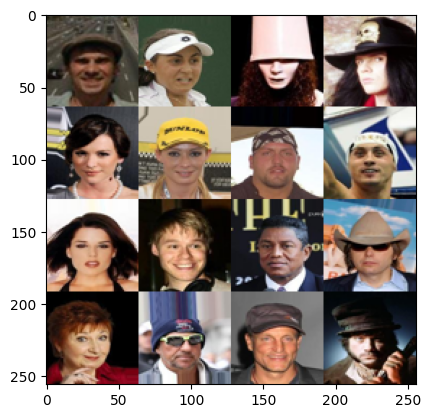

In [17]:
i=0
img1=np.concatenate((test[i],test[i+1],test[i+2],test[i+3]),axis=1)
img2=np.concatenate((test[i+4],test[i+5],test[i+6],test[i+7]),axis=1)
img3=np.concatenate((test[i+8],test[i+9],test[i+10],test[i+11]),axis=1)
img4=np.concatenate((test[i+12],test[i+13],test[i+14],test[i+15]),axis=1)
img=np.concatenate((img1,img2,img3,img4),axis=0)
plt.imshow(img)

## Random seed
Set the random seed to a certain value for reproducibility.

In [5]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(3407)

# Autoencoder

# Models & loss

In [6]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )    # Hint: dimension of latent space can be adjusted

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 64 * 3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )   # Hint:  dimension of latent space can be adjusted
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        # Hint: can add more layers to encoder and decoder
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

In [7]:
class Residual_Block(nn.Module):
    def __init__(self, ic, oc, stride=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(ic, oc, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(oc),
            nn.ReLU(inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(oc, oc, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(oc),
        )
        
        self.relu = nn.ReLU(inplace=True)
    
        self.downsample = None
        if stride != 1 or (ic != oc):
            self.downsample = nn.Sequential(
                nn.Conv2d(ic, oc, kernel_size=1, stride=stride),
                nn.BatchNorm2d(oc),
            )
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:
            residual = self.downsample(x)
            
        out += residual
        return self.relu(out)
    
class ResNet(nn.Module):
    def __init__(self, block=Residual_Block, num_layers=[2, 1, 1, 1]):
        super().__init__()
        self.preconv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.layer0 = self.make_residual(block, 32, 64,  num_layers[0], stride=2)
        self.layer1 = self.make_residual(block, 64, 128, num_layers[1], stride=2)
        self.layer2 = self.make_residual(block, 128, 128, num_layers[2], stride=2)
        self.layer3 = self.make_residual(block, 128, 64, num_layers[3], stride=2)
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64*4*4, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 64*4*4),
            nn.BatchNorm1d(64*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )
    def make_residual(self, block, ic, oc, num_layer, stride=1):
        layers = []
        layers.append(block(ic, oc, stride))
        for i in range(1, num_layer):
            layers.append(block(oc, oc))
        return nn.Sequential(*layers)
    
    def encoder(self, x):
        x = self.preconv(x)
        x = self.layer0(x) #64*64 --> 32*32
        x = self.layer1(x) #32*32 --> 16*16
        x = self.layer2(x) #16*16 --> 8*8
        x = self.layer3(x) #8*8 --> 4*4
        x = self.fc(x)
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class Auxiliary(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(64, 64*4*4),
            nn.BatchNorm1d(64*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.decoder(x)

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [8]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)

        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])

    def __getitem__(self, index):
        x = self.tensors[index]

        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [18]:
# Training hyperparameters
num_epochs = 100
batch_size = 128 # Hint: batch size may be lower
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'fcn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE(), 'resnet':ResNet()}
model = model_classes[model_type].cuda()


aux = Auxiliary().cuda()

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
optimizer_a = torch.optim.AdamW(aux.parameters(), lr=learning_rate)

## Training loop

In [20]:
best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
      'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))


 Iters    Elapsed Time      Speed                                               
 0/100          -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/100  00:00:09<00:14:52  0.11it/s  1/100  0.1661                              
Description   1.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 2/100  00:00:18<00:14:43  0.11it/s  2/100  0.1483                              
Description   2.0% |█                                                          | Iters    Elapsed Time      Speed    epoch   loss                               
 3/100  00:00:27<00:14:39  0.11it/s  3/100  0.1459                              
Description   3.0% |█                                                          | Iters    Elapsed Time      Spee

In [19]:
best_loss = np.inf

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'), dynamic_ncols=False)
for epoch in qqdm_train:
    tot_loss = list()
    tot_loss_a = list()
    aux.train()
    temperature = epoch // 2 + 1
    for data in train_dataloader:
        # ===================loading=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)
        # ===================train autoencoder=====================
        model.train()
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)
        loss = loss.mean()
        tot_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================train aux=====================
        model.eval()
        z = model.encoder(img).detach_()
        output = output.detach_()
        output_a = aux(z)
        loss_a = (criterion(output_a, output).mul(temperature).exp())*criterion(output_a, img)
        loss_a = loss_a.mean()
        tot_loss_a.append(loss_a.item())
        optimizer_a.zero_grad()
        loss_a.backward()
        optimizer_a.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
        torch.save(aux, 'best_model_a_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss':f'{np.mean(tot_loss):.5f}',
        'loss_a':f'{np.mean(tot_loss_a):.5f}'
    })


# ===================save_last========================
torch.save(model, 'last_model_{}.pt'.format(model_type))
torch.save(aux, 'last_model_a_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                               
 0/100          -             -                                                 
Description   0.0% |                                       |                     Iters    Elapsed Time      Speed                                               
 0/100          -             -                                                 
Description   0.0% |                                       |                    

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x3 and 64x1024)

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [11]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'best_model_{model_type}.pt'
checkpoint_path_a = f'best_model_a_{model_type}.pt'
model = torch.load(checkpoint_path).cuda()
aux = torch.load(checkpoint_path_a).cuda()
model.eval()

# prediction file
out_file = 'prediction_resnet.csv'
out_file_a = 'prediction_a_resnet.csv'

In [12]:
anomality = list()
auxs = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    img = data.float().cuda()
    if model_type in ['fcn']:
      img = img.view(img.shape[0], -1)
    z = model.encoder(img)
    output, output_a = model.decoder(z), aux(z)
    if model_type in ['vae']:
      output = output[0]
    if model_type in ['fcn']:
        loss = eval_loss(output, img).mean(-1)
    else:
        loss = eval_loss(output, img).mean([1, 2, 3])
        loss_a = eval_loss(output_a, img).mean([1, 2, 3])
    anomality.append(loss)
    auxs.append(loss_a)

anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()
auxs = torch.cat(auxs, axis=0)
auxs = torch.sqrt(auxs).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')
df_a = pd.DataFrame(auxs, columns=['score'])
df_a.to_csv(out_file_a, index_label = 'ID')

## Report Question 2

Train a fully connected autoencoder and adjust at least two different
element of the latent representation. Show your model architecture, plot
out the original image, the reconstructed images for each adjustment and
describe the differences.

In [ ]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'last_model_{model_type}.pt'
model = torch.load(checkpoint_path)
model.eval()

# prediction file 
out_file = 'prediction_fcn.csv'

In [ ]:
anomality = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader): 
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)
        else:
            img = data[0].cuda()
        output = model(img)
        if model_type in ['cnn', 'resnet', 'fcn']:
            output = output
        elif model_type in ['res_vae']:
            output = output[0]
        elif model_type in ['vae']: # , 'vqvae'
            output = output[0]
        if model_type in ['fcn']:
            loss = eval_loss(output, img).sum(-1)
        else:
            loss = eval_loss(output, img).sum([1, 2, 3])
        anomality.append(loss)
anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'Id')

In [25]:
# Get some test images
# img = images.view(test[0].size(0), -1)
img = test[0]
# Encode the image
encoded_img = model.encoder(img)

# Adjust the latent representation
adjusted_img1 = encoded_img.clone()
adjusted_img2 = encoded_img.clone()
adjusted_img1[0, 0] += 1  # Adjust the first element
adjusted_img2[0, 1] += 1  # Adjust the second element

# Decode the adjusted images
reconstructed_img1 = fcn_autoencoder.decoder(adjusted_img1)
reconstructed_img2 = fcn_autoencoder.decoder(adjusted_img2)

# Plot the images
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Original Image
axs[0].imshow(img.view(28, 28).detach().numpy(), cmap='gray')
axs[0].set_title('Original Image')

# Reconstructed Image 1
axs[1].imshow(reconstructed_img1.view(28, 28).detach().numpy(), cmap='gray')
axs[1].set_title('Reconstructed Image 1\n(Adjusting latent[0])')

# Reconstructed Image 2
axs[2].imshow(reconstructed_img2.view(28, 28).detach().numpy(), cmap='gray')
axs[2].set_title('Reconstructed Image 2\n(Adjusting latent[1])')

for ax in axs:
    ax.axis('off')

plt.show()


TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class FCNAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(FCNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 64 * 3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [27]:
def plot_images(original, reconstructed, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(reconstructed)
    axs[1].set_title(title)
    axs[1].axis('off')

    plt.show()


100%|██████████| 170498071/170498071 [00:11<00:00, 15371820.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Training autoencoder with latent dimension: 3


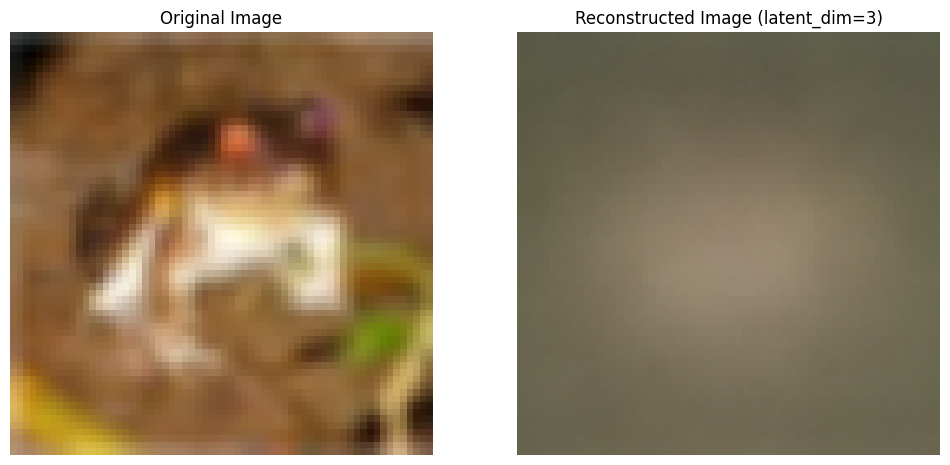

Training autoencoder with latent dimension: 6


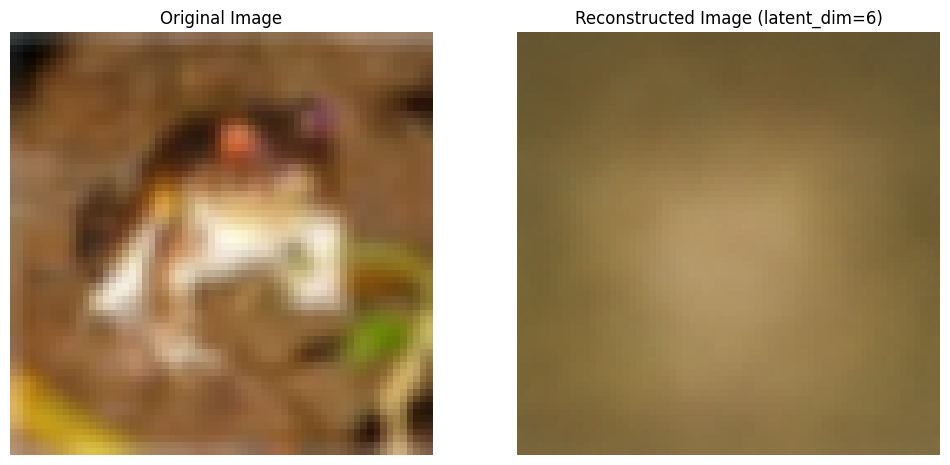

Training autoencoder with latent dimension: 12


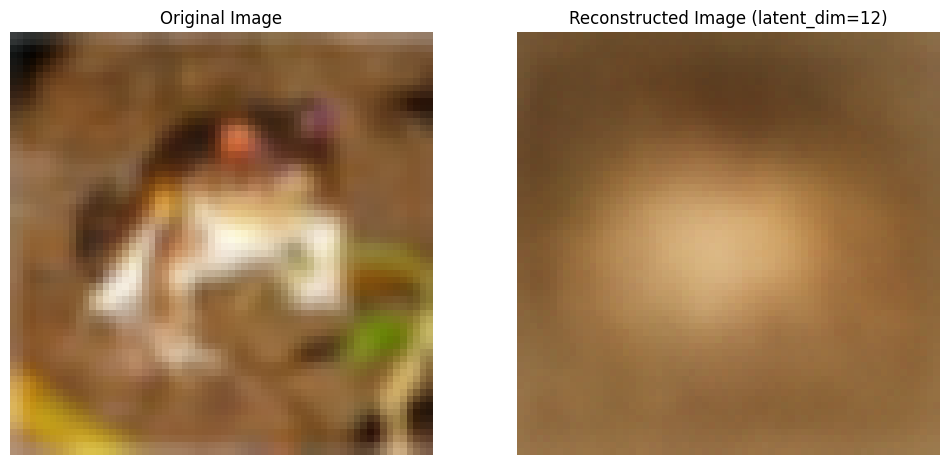

In [28]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 加载和预处理数据
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

def train_autoencoder(model, num_epochs=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for data in dataloader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img = img.cuda()

            output = model(img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

# 将数据转换为numpy array
def to_npimg(img):
    img = img.view(3, 64, 64).detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1) / 2  # 反归一化
    return img

# 获取一个测试图像
test_img, _ = dataset[0]
test_img = test_img.view(-1).unsqueeze(0).cuda()

# 调整latent dimension为不同值进行训练和测试
latent_dims = [3, 6, 12]
original_img = to_npimg(test_img)

for latent_dim in latent_dims:
    print(f'Training autoencoder with latent dimension: {latent_dim}')
    model = FCNAutoencoder(latent_dim).cuda()
    model = train_autoencoder(model, num_epochs=5)

    reconstructed_img = model(test_img)
    reconstructed_img = to_npimg(reconstructed_img)

    plot_images(original_img, reconstructed_img, f'Reconstructed Image (latent_dim={latent_dim})')
